<a href="https://colab.research.google.com/github/talaabusoud/diabetes-prediction-ml/blob/main/Diabetes_Diagnosis_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diabetes Diagnosis Predictor
- Author: Tala AbuSoud

**Diabetes Prediction Using Machine Learning**

This project focuses on predicting the likelihood of diabetes in patients using machine learning techniques, based on diagnostic health measurements. The aim is to build a reliable classification model that can assist in early detection of diabetes, which is critical for timely medical intervention.

We use the [Diabetes Dataset](https://drive.google.com/file/d/1rf9WR1RLC3ynMYybAp_p70JgwdcajDhq/view?usp=sharing), which includes several physiological measurements (such as glucose level, BMI, and blood pressure) along with a binary outcome indicating whether the patient has diabetes.
A complete [data dictionary](https://docs.google.com/document/d/1QNZHliysHgTINXNo-IUZHDhzKnpI7mfia4gaKJ-97tg/edit?tab=t.0) is available to describe the features and value meanings in the dataset.

The workflow includes:
- **Data cleaning:** Addressing missing values, correcting inconsistent entries, and handling biologically impossible values.

- **Exploratory Data Analysis (EDA):** Visualizing distributions and relationships to uncover insights and patterns.

- **Preprocessing:** Implementing scalable, leakage-free pipelines for encoding, imputation, and feature scaling.

- **Modeling:** Comparing multiple classification models (Logistic Regression, Random Forest, and K-Nearest Neighbors) with both default and tuned hyperparameters.

- **Evaluation:** Using metrics like accuracy, F1-score, and ROC-AUC to select the best-performing model.

- **Final conclusion:** Choosing and justifying the most suitable model based on performance and interpretability.

The project uses Python libraries such as `Pandas`, `Scikit-learn`, `Seaborn`, and `Matplotlib`, and is developed in Google Colab. The entire pipeline is built with reproducibility and real-world deployment in mind.

# **Loading data**

In [ ]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.compose import make_column_transformer, ColumnTransformer, make_column_selector
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn import set_config
set_config(transform_output='pandas')
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, \
ConfusionMatrixDisplay, accuracy_score, classification_report, roc_auc_score, RocCurveDisplay
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
import missingno as msno
from imblearn.pipeline import make_pipeline as make_sampler_pipeline

In [ ]:
fpath='/content/drive/MyDrive/AXSOSACADEMY/AXSOSACADEMY/02-IntroML/Belt2_B_diabetes_v2_final.csv'
df=pd.read_csv(fpath)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 642 entries, 0 to 641
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               642 non-null    int64  
 1   Glucose                   638 non-null    float64
 2   BloodPressure             616 non-null    float64
 3   SkinThickness             455 non-null    float64
 4   Insulin                   331 non-null    float64
 5   DiabetesPedigreeFunction  642 non-null    object 
 6   WeightGroup               642 non-null    object 
 7   AgeGroup                  642 non-null    object 
 8   Gender                    642 non-null    object 
 9   Outcome                   642 non-null    int64  
dtypes: float64(4), int64(2), object(4)
memory usage: 50.3+ KB


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,DiabetesPedigreeFunction,WeightGroup,AgeGroup,Gender,Outcome
0,4,189.0,110.0,31.0,NaN,0_68,overweight,18 - 44,F,0
1,2,157.0,74.0,35.0,440.0,0.134,obese_2,18 - 44,F,0
2,6,98.0,58.0,33.0,190.0,0.43,obese_1,18 - 44,F,0
3,6,111.0,64.0,39.0,NaN,0.26,obese_1,18 - 44,F,0
4,3,106.0,72.0,NaN,NaN,0_207,overweight,18 - 44,F,0


In [ ]:
df.shape

(642, 10)

* The data set contains 642 rows and 10 columns.

# **1) Data Cleaning**

## 1.a: Checking for nulls

In [ ]:
df.isna().sum()

,0
Pregnancies,0
Glucose,4
BloodPressure,26
SkinThickness,187
Insulin,311
DiabetesPedigreeFunction,0
WeightGroup,0
AgeGroup,0
Gender,0
Outcome,0


In [ ]:
df.isna().sum().sum()

np.int64(528)

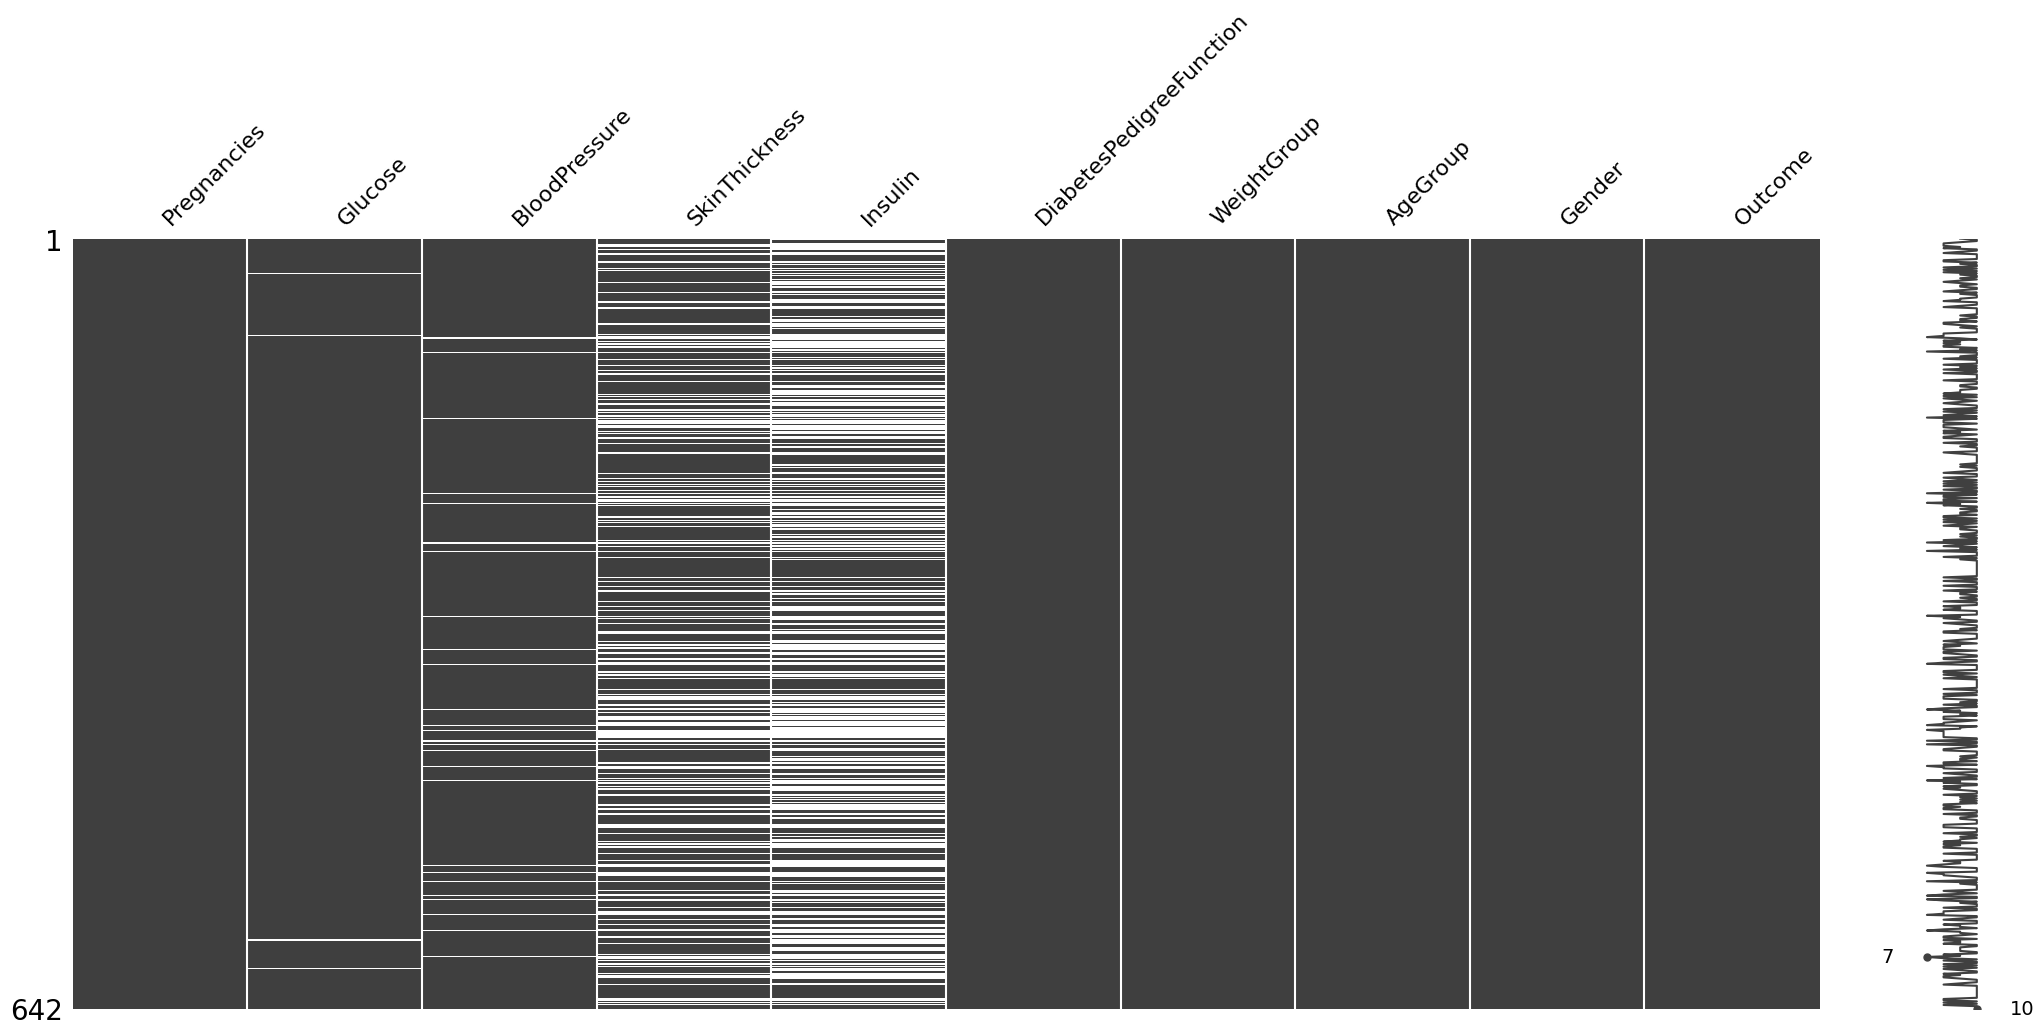

In [ ]:
# Visualize the missing values using the missingno matrix plot.
msno.matrix(df);

There is no missing values in categorical data type features. But for numeric ones The dataset has a total of 528 missing entries in the Glucose, BloodPressure, SkinThickness and Insulin features.
- Glucose: 4/642 --> 0.62%
- BloodPressure: 26/642 --> 4.05%
- SkinThickness: 187/642 --> 29.13%
- Insulin: 311/642 --> 48.44%

We will impute the missing values later in the preprocessing stage

## 1.b: Checking Data Types

In [ ]:
df.dtypes

,0
Pregnancies,int64
Glucose,float64
BloodPressure,float64
SkinThickness,float64
Insulin,float64
DiabetesPedigreeFunction,object
WeightGroup,object
AgeGroup,object
Gender,object
Outcome,int64


* `DiabetesPedigreeFunction` feature must be converted to numeric

In [ ]:
df['DiabetesPedigreeFunction'].value_counts()

,count
DiabetesPedigreeFunction,
0.254,5
0.19699999999999998,4
0.349,4
0.23800000000000002,4
0.258,4
...,...
0.63,1
0_605,1
0_34700000000000003,1


- handling inconsistent values in `DiabetesPedigreeFunction` column

In [ ]:
df['DiabetesPedigreeFunction']=df['DiabetesPedigreeFunction'].str.replace('_','.')
df['DiabetesPedigreeFunction'].value_counts()

,count
DiabetesPedigreeFunction,
0.261,5
0.254,5
0.258,4
0.284,4
0.19699999999999998,4
...,...
1.893,1
0.759,1
0.431,1


* Convert it to a float

In [ ]:
df['DiabetesPedigreeFunction']=df['DiabetesPedigreeFunction'].astype(float)
df['DiabetesPedigreeFunction'].dtype

dtype('float64')

## 1.c: Checking inconsistent values in categorical features

In [ ]:
inc_col=df.select_dtypes('object')
# loop through the list of string columns
for col in inc_col:
  print(f'Value For {col} column is: ')
  print(df[col].value_counts())
  print('\n')

Value For WeightGroup column is: 
WeightGroup
obese_1           196
overweight        146
obese_2           126
obsese_3           87
healthy weight     75
MISSING             8
underweight         4
Name: count, dtype: int64


Value For AgeGroup column is: 
AgeGroup
18 - 44    528
45 - 64    103
>65          8
<65          3
Name: count, dtype: int64


Value For Gender column is: 
Gender
F    565
M     60
m     17
Name: count, dtype: int64




### Fixing inconsistent values: `WeightGroup`

In [ ]:
df['WeightGroup'] = df['WeightGroup'].replace('obsese_3', 'obese_3')
df['WeightGroup'] = df['WeightGroup'].replace('MISSING', np.nan)
df['WeightGroup'].value_counts()

,count
WeightGroup,
obese_1,196
overweight,146
obese_2,126
obese_3,87
healthy weight,75
underweight,4


- Replace the value of obsese_3 to obese_3 to match the dictionary.
- Replace the MISSING with nulls so we can impute them later in preprocessing stage.

### Fixing inconsistent values: `AgeGroup`

In [ ]:
df['AgeGroup'] = df['AgeGroup'].replace({
    '<65': '45 - 65',
    '45 - 64': '45 - 65'
})
df['AgeGroup'].value_counts()

,count
AgeGroup,
18 - 44,528
45 - 65,106
>65,8


- fix the Age groups to match the data dictionary.

### Fixing inconsistent values: `Gender`

In [ ]:
df['Gender'] = df['Gender'].str.upper()
df['Gender'].value_counts()

,count
Gender,
F,565
M,77


- Make all values in upper case to be consistent.

## 1.d: Checking impossible values in numeric columns

In [ ]:
df.describe().round(3)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,DiabetesPedigreeFunction,Outcome
count,642.000,638.000,616.000,455.000,331.000,642.000,642.000
mean,5.453,124.044,72.398,29.484,158.997,0.475,0.422
std,39.460,30.757,12.307,10.527,117.255,0.333,0.494
min,0.000,56.000,24.000,7.000,14.000,0.085,0.000
25%,1.000,100.000,64.000,22.000,82.500,0.247,0.000
50%,3.000,121.000,72.000,30.000,130.000,0.378,0.000
75%,6.000,144.000,80.000,36.500,192.500,0.630,1.000
max,1000.000,199.000,114.000,99.000,846.000,2.420,1.000


- Pregnancies: the max is 1000 which is impossible as [the max time of pregnancies recorded is 27](https://businessday.ng/life-arts/article/woman-who-gave-birth-to-69-children-in-76-years/#:~:text=Valentina%20Vassilyev%20is%20the%20world's,times%20between%201725%20and%201765.&text=She%20and%20her%20husband%2C%20Feodor,away%20at%2076%20years%20old.)

- BloodPressure: Min = 24 is invalid, diastolic minimum pressure for living person cannot be less that 40 (this information should be verified by a qualified doctor or medical specialist.)


### Fixing impossible values: `Pregnancies`

In [ ]:
(df['Pregnancies'] > 27).sum()

np.int64(1)

In [ ]:
wrong_preg = (df['Pregnancies'] > 27)
df[wrong_preg].head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,DiabetesPedigreeFunction,WeightGroup,AgeGroup,Gender,Outcome
371,1000,163.0,72.0,41.0,114.0,0.817,obese_3,45 - 65,F,1


One row had an impossible value of 1000 for the `Pregnancies` column. Based on domain knowledge and surrounding context (`AgeGroup` = 45–65), we assumed this was a data entry error and corrected it to 10.
We could have dropped the row since it's only one, but since the other medical data is realistic, it might be beneficial to keep it.

In [ ]:
df['Pregnancies'] = df['Pregnancies'].replace(1000, 10)
df[wrong_preg].head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,DiabetesPedigreeFunction,WeightGroup,AgeGroup,Gender,Outcome
371,10,163.0,72.0,41.0,114.0,0.817,obese_3,45 - 65,F,1


### Fixing impossible values: `BloodPressure`

In [ ]:
wrong_press = (df['BloodPressure'] < 40)
df[wrong_press].head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,DiabetesPedigreeFunction,WeightGroup,AgeGroup,Gender,Outcome
275,1,89.0,24.0,19.0,25.0,0.559,overweight,18 - 44,F,0
281,1,103.0,30.0,38.0,83.0,0.183,obese_3,18 - 44,F,0
626,1,88.0,30.0,42.0,99.0,0.496,obese_3,18 - 44,F,1


since there are only 3 rows with unrealistic diastolic blood pressure values (<40 mm Hg), which represent less than 0.5% of the dataset, we have 2 options either drop them, or replace them with Nulls and impute them later.
In this case, because the rest of the data in these rows is valid, I think the more professional approach is to replace the invalid values with NaN and impute them later. This preserves potentially valuable information without introducing bias.

In [ ]:
df.loc[df['BloodPressure'] < 40, 'BloodPressure'] = np.nan
df[wrong_press].head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,DiabetesPedigreeFunction,WeightGroup,AgeGroup,Gender,Outcome
275,1,89.0,NaN,19.0,25.0,0.559,overweight,18 - 44,F,0
281,1,103.0,NaN,38.0,83.0,0.183,obese_3,18 - 44,F,0
626,1,88.0,NaN,42.0,99.0,0.496,obese_3,18 - 44,F,1


## 1.e: Checking for duplicates

In [ ]:
df.duplicated().sum()

np.int64(3)

* There is 3 rows that are duplicated

In [ ]:
dup = df.duplicated(keep=False)
df[dup]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,DiabetesPedigreeFunction,WeightGroup,AgeGroup,Gender,Outcome
400,1,126.0,60.0,NaN,NaN,0.349,obese_1,45 - 65,F,1
463,1,126.0,60.0,NaN,NaN,0.349,obese_1,45 - 65,F,1
536,0,137.0,40.0,35.0,168.0,2.288,obese_3,18 - 44,M,1
582,8,183.0,64.0,NaN,NaN,0.672,healthy weight,18 - 44,F,1
601,8,183.0,64.0,NaN,NaN,0.672,healthy weight,18 - 44,F,1
618,0,137.0,40.0,35.0,168.0,2.288,obese_3,18 - 44,M,1


* Drop duplicates

In [ ]:
df = df.drop_duplicates()
df.duplicated().sum()

np.int64(0)

## 1.f: Checking the cardinality of categorical features

In [ ]:
cat = df.select_dtypes('object').columns
df[cat].describe()

,WeightGroup,AgeGroup,Gender
count,631,639,639
unique,6,3,2
top,obese_1,18 - 44,F
freq,195,526,563


* There are no features with high cardinality.

# **2) Exploring data**

* Define EDA classifications functions

In [ ]:
#EDA1 - categorical_vs_target
def plot_categorical_vs_target(df, x, y, figsize=(6,4),
                            fillna = True, placeholder = 'MISSING',
                            order = None, target_type='reg'):
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)
  # REGRESSION-TARGET PLOT
  if target_type=='reg': #Added if statement here
    # Barplot
    sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
                linewidth=1, edgecolor='black', errorbar=None)
    # Boxplot
    sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax,
                  order=order, hue_order=order, legend=False,
                  edgecolor='white', linewidth=0.5,
                  size=3,zorder=0)
  # CLASSIFICATION-TARGET PLOT # This is the new code for the classification task
  elif target_type=='class':
    ax = sns.histplot(data=temp_df, hue=y, x=x, stat='percent',  multiple='fill')
  # Rotate xlabels
  ax.set_xticks(ax.get_xticks()) # Added this to prevent a bug
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title
  ax.set_title(f"{x} vs. {y}")
  fig.tight_layout()
  return fig, ax

########################################
# EDA1 - numeric_vs_target
def plot_numeric_vs_target(df, x, y, figsize=(6,4),
                           target_type='reg', estimator='mean',
                           errorbar='ci',sorted=False,ascending=False,
                           **kwargs): # kwargs for sns.regplot

  nulls = df[[x,y]].isna().sum()
  if nulls.sum()>0:
    print(f"- Excluding {nulls.sum()} NaN's")
    # print(nulls)
    temp_df = df.dropna(subset=[x,y,])
  else:
    temp_df = df
  # Create the figure
  fig, ax = plt.subplots(figsize=figsize)

  # REGRESSION-TARGET PLOT
  if 'reg' in target_type:
    # Calculate the correlation
    corr = df[[x,y]].corr().round(2)
    r = corr.loc[x,y]
    # Plot the data
    scatter_kws={'edgecolor':'white','linewidths':1,'alpha':0.8}
    sns.regplot(data=temp_df, x=x, y=y, ax=ax, scatter_kws=scatter_kws, **kwargs) # Included the new argument within the sns.regplot function
    ## Add the title with the correlation
    ax.set_title(f"{x} vs. {y} (r = {r})")

  # CLASSIFICATION-TARGET PLOT
  elif 'class' in target_type:

    # Sort the groups by median/mean
    if sorted == True:

      if estimator == 'median':
        group_vals = temp_df.groupby(y)[x].median()
      elif estimator =='mean':
        group_vals = temp_df.groupby(y)[x].mean()

      ## Sort values
      group_vals = group_vals.sort_values(ascending=ascending)
      order = group_vals.index

    else:
      # Set order to None if not calcualted
      order = None


    # Left Subplot (barplot)
    sns.barplot(data=temp_df, x=y, y=x, order=order,  estimator=estimator,
                errorbar=errorbar, ax=ax, **kwargs)

    # Add title
    ax.set_title(f"{x} vs. {y}")

    # rotate xaxis labels
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


  # Final Adjustments & return
  fig.tight_layout()
  fig.show()
  return fig, ax

## 2.a: Categroical vs Target

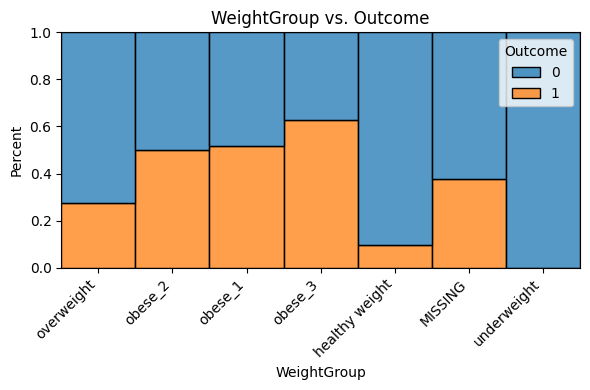

In [ ]:
plot_categorical_vs_target(df, 'WeightGroup', 'Outcome', target_type='class');

The visualization shows that people are more likely to have diabetes (Outcome = 1) as their weight category goes up. In particular, those in the obese groups (obese_3, obese_1, and obese_2) have the most diabetes cases, while people who are underweight or at a healthy weight mostly don’t have diabetes (Outcome = 0).

## 2.b: Numaric vs Target

- Excluding 4 NaN's


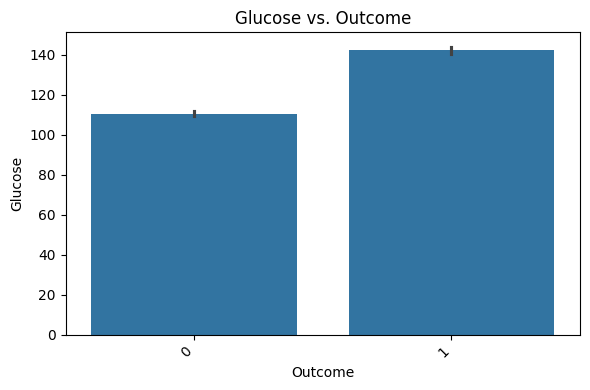

In [ ]:
plot_numeric_vs_target(df, x='Glucose', y='Outcome', target_type='class', errorbar='se');

We used the mean as the estimator because the Glucose distribution is only slightly skewed with no strong outliers, making the average a reliable measure of central tendency, and we included standard error (errorbar='se') to show the uncertainty around the mean estimates for each class.

The visualization shows that people with diabetes usually have higher average plasma glucose concentration (glucose) levels than those without diabetes. This means that higher glucose levels are linked to a greater chance of having diabetes.

## 2.c: Heatmap

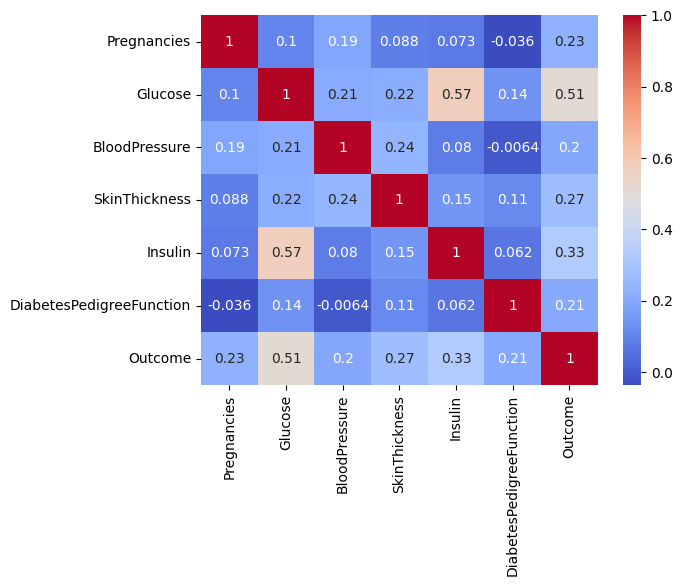

In [ ]:
corr = df.corr(numeric_only = True)
ax = sns.heatmap(corr, cmap = 'coolwarm', annot = True);

The correlation heatmap shows that `Glucose` has the strongest positive correlation with Outcome (r = 0.51), indicating that its the key predictor of diabetes. Other features like `Insulin`, `SkinThickness`, and `Pregnancies` show moderate correlations, while `DiabetesPedigreeFunction` and `BloodPressure` have weaker associations with the target.

# **3) Preprocessing**

In [ ]:
# cheack for class balance
df['Outcome'].value_counts(normalize=True)

,proportion
Outcome,
0,0.580595
1,0.419405


* The data is nearly balanced, so there is no need to do something

In [ ]:
# Make X and y
y = df['Outcome']
X = df.drop(columns=['Outcome'])

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 479 entries, 305 to 102
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               479 non-null    int64  
 1   Glucose                   475 non-null    float64
 2   BloodPressure             458 non-null    float64
 3   SkinThickness             340 non-null    float64
 4   Insulin                   244 non-null    float64
 5   DiabetesPedigreeFunction  479 non-null    float64
 6   WeightGroup               477 non-null    object 
 7   AgeGroup                  479 non-null    object 
 8   Gender                    479 non-null    object 
dtypes: float64(5), int64(1), object(3)
memory usage: 37.4+ KB


## Ordinal features

In [ ]:
# define ordinal features
ord_cols = ['WeightGroup','AgeGroup']

# impute nulls with most_frequent
impute_common = SimpleImputer(strategy='most_frequent')

# orders
weight_order = ['underweight', 'healthy weight', 'overweight', 'obese_1', 'obese_2', 'obese_3']
age_order = ['18 - 44', '45 - 65', '>65']

# ordinal encoder
ord_encoder = OrdinalEncoder(categories=[weight_order, age_order])

# scaling
scaler = StandardScaler()

# instantiate the pipeline
ord_pipe = make_pipeline(impute_common, ord_encoder, scaler)

# make a tuple for column transformer
ord_tuple = ('ordinal',ord_pipe, ord_cols)
ord_tuple

('ordinal',
 Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                 ('ordinalencoder',
                  OrdinalEncoder(categories=[['underweight', 'healthy weight',
                                              'overweight', 'obese_1', 'obese_2',
                                              'obese_3'],
                                             ['18 - 44', '45 - 65', '>65']])),
                 ('standardscaler', StandardScaler())]),
 ['WeightGroup', 'AgeGroup'])

We used ordinal encoding for `WeightGroup` and `AgeGroup` because their categories have a natural order. For example, weight groups go from underweight to obese, and age groups go from younger to older. Using ordinal encoding helps the model understand this order.

## Categorical features

In [ ]:
# define categorical features
cat_cols = ['Gender']

# impute nulls with MISSING
# but since we dont have null it's not required but i will keep it
impute_missing = SimpleImputer(strategy='constant',fill_value='MISSING')

# one hot encoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# instantiate the pipeline
cat_pipe = make_pipeline(impute_missing, ohe)

# make a tuple for column transformer
cat_tuple = ('nominal',cat_pipe, cat_cols)
cat_tuple

('nominal',
 Pipeline(steps=[('simpleimputer',
                  SimpleImputer(fill_value='MISSING', strategy='constant')),
                 ('onehotencoder',
                  OneHotEncoder(handle_unknown='ignore', sparse_output=False))]),
 ['Gender'])

We used one-hot encoding for `Gender` because it has no order (just "M" and "F"). One-hot encoding treats each category separately without implying any ranking.

## Numerical features

In [ ]:
# define numerical features
num_cols = X_train.select_dtypes("number").columns

# scaling
scaler = StandardScaler()

# impute nulls with median
median_imputer = SimpleImputer(strategy='median')

# instantiate the pipeline
num_pipe = make_pipeline(median_imputer, scaler)

# make the tuple for ColumnTransformer
num_tuple = ('numeric',num_pipe, num_cols)
num_tuple

('numeric',
 Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                 ('standardscaler', StandardScaler())]),
 Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
        'DiabetesPedigreeFunction'],
       dtype='object'))

For the four columns with missing values `Glucose`, `BloodPressure`, `SkinThickness`, and `Insulin`, it's better to fill in the missing data using the median. This is because the median isn't affected much by outliers, so it gives a more reliable estimate of the typical value in each column.

In [ ]:
df.isna().sum()

,0
Pregnancies,0
Glucose,4
BloodPressure,29
SkinThickness,185
Insulin,309
DiabetesPedigreeFunction,0
WeightGroup,8
AgeGroup,0
Gender,0
Outcome,0


In [ ]:
df[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin']].describe()

,Glucose,BloodPressure,SkinThickness,Insulin
count,635.000000,610.000000,454.000000,330.000000
mean,123.927559,72.703279,29.471366,158.969697
std,30.735995,11.875054,10.535877,117.432069
min,56.000000,40.000000,7.000000,14.000000
25%,100.000000,64.000000,22.000000,82.250000
50%,120.000000,72.000000,30.000000,130.000000
75%,144.000000,80.000000,36.750000,192.750000
max,199.000000,114.000000,99.000000,846.000000


## Instantiate the ColumnTransformer

In [ ]:
# Instantiate with verbose_feature_names_out=False
preprocessor = ColumnTransformer([ord_tuple, cat_tuple, num_tuple],
                                    verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['underweight',
                                                                              'healthy '
                                                                              'weight',
                                                                              'overweight',
                                                                              'obese_1',
                                                                              'obese_2',
                                                                              'obese_3'],
                                                                             ['18 '
                                                                              '- '
                                                                              '44',
                                                                              '45 '
                                                                              '- '
                                                                              '65',
                                                                              '>65']])),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['WeightGroup', 'AgeGroup']),
                                ('nominal'...
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Gender']),
                                ('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'DiabetesPedigreeFunction'],
      dtype='object'))],
                  verbose_feature_names_out=False)

# **4) Modeling**

In this step, three models (Logistic Regression, Random Forest, and K-Nearest Neighbors) will be created and compared to predict diabetes.

In [ ]:
# Difine Classification Evaluation Functions
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict

def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

## **4.1: Logistic Regression**

### 4.1.a: Default Logistic Regression Model

In [ ]:
# Make an instance of the model
logreg = LogisticRegression(max_iter=500, random_state=42)

# Create pipeline
logreg_pipe = make_pipeline(preprocessor, logreg)

# Training the model on the data, storing the information learned from the data
# Model is learning the relationship between X and y
logreg_pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['underweight',
                                                                                               'healthy '
                                                                                               'weight',
                                                                                               'overweight',
                                                                                               'obese_1',
                                                                                               'obese_2',
                                                                                               'obese_3'],
                                                                                              ['18 '
                                                                                               '- '
                                                                                               '44',
                                                                                               '45 '
                                                                                               '- '
                                                                                               '65',
                                                                                               '>65']])),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  [...
                                                  ['Gender']),
                                                 ('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'DiabetesPedigreeFunction'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('logisticregression',
                 LogisticRegression(max_iter=500, random_state=42))])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.75      0.80      0.78       260
           1       0.74      0.69      0.72       219

    accuracy                           0.75       479
   macro avg       0.75      0.74      0.75       479
weighted avg       0.75      0.75      0.75       479



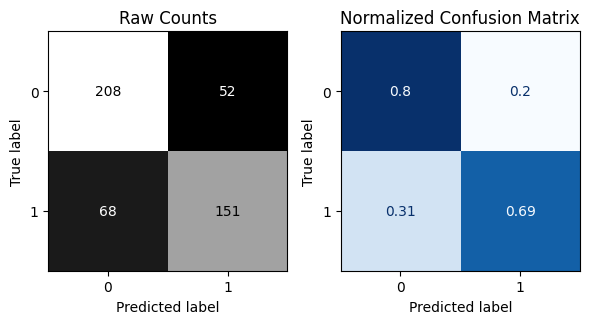


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.77      0.80       111
           1       0.56      0.65      0.60        49

    accuracy                           0.74       160
   macro avg       0.70      0.71      0.70       160
weighted avg       0.75      0.74      0.74       160



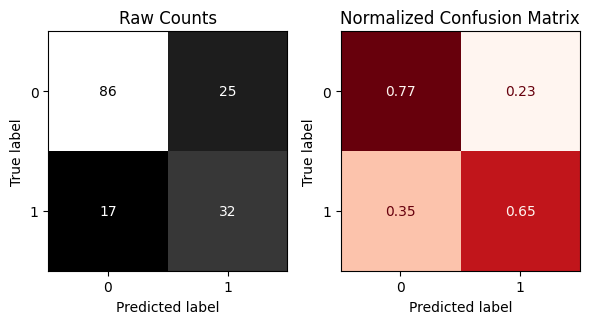

In [ ]:
evaluate_classification(logreg_pipe, X_train, y_train, X_test, y_test)

The logistic regression model shows moderate performance with a recall of 0.65 for diabetic patients on the test set, meaning it correctly identifies about 65% of true cases.

### 4.1.b: Hyperparameter Tuning using GridSearchCV

In [ ]:
logreg_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('ordinal',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('ordinalencoder',
                                                     OrdinalEncoder(categories=[['underweight',
                                                                                 'healthy '
                                                                                 'weight',
                                                                                 'overweight',
                                                                                 'obese_1',
                                                                                 'obese_2',
                                                                                 'obese_3'],
                

In [ ]:
param_grid = [
    {
        'logisticregression__solver': ['liblinear'],
        'logisticregression__penalty': ['l1', 'l2'],
        'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'logisticregression__class_weight': ['balanced', None]
    },
    {
        'logisticregression__solver': ['lbfgs', 'newton-cg', 'sag'],
        'logisticregression__penalty': ['l2'],
        'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'logisticregression__class_weight': ['balanced', None]
    },
    {
        'logisticregression__solver': ['saga'],
        'logisticregression__penalty': ['l1', 'l2', 'elasticnet'],
        'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'logisticregression__class_weight': ['balanced', None],
        'logisticregression__l1_ratio': [0.0, 0.5, 1.0]
    }
]

gs_logreg = GridSearchCV(logreg_pipe, param_grid, verbose=True, n_jobs=-1,
                  return_train_score=True,scoring='recall_macro')

gs_logreg.fit(X_train, y_train)
print(f'Best Params: {gs_logreg.best_params_}')

Fitting 5 folds for each of 224 candidates, totalling 1120 fits
Best Params: {'logisticregression__C': 0.1, 'logisticregression__class_weight': 'balanced', 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}


----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.77      0.78       260
           1       0.73      0.74      0.74       219

    accuracy                           0.76       479
   macro avg       0.76      0.76      0.76       479
weighted avg       0.76      0.76      0.76       479



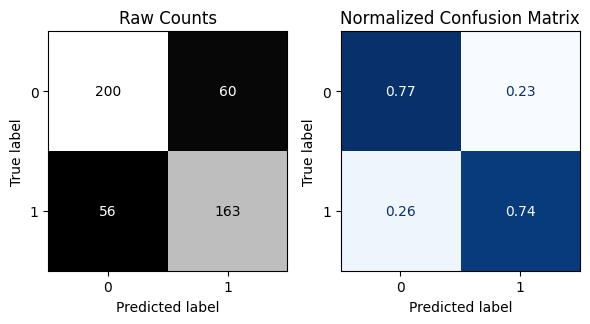


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.75      0.79       111
           1       0.54      0.67      0.60        49

    accuracy                           0.72       160
   macro avg       0.69      0.71      0.70       160
weighted avg       0.75      0.72      0.73       160



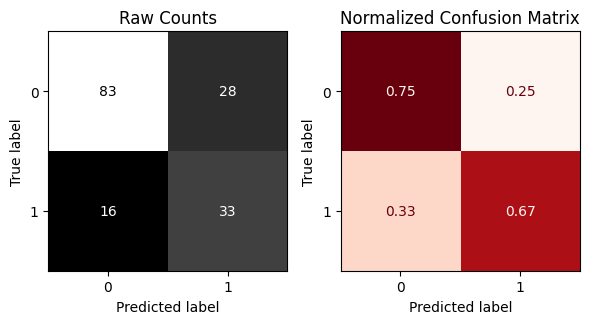

In [ ]:
best_logreg = gs_logreg.best_estimator_
evaluate_classification(best_logreg, X_train, y_train, X_test, y_test)

### 4.1.c: Evaluate Both Default and Tuned

<table style="width:100%; table-layout: fixed;">
  <tr>
    <th></th>
    <th style="text-align:center;">Default</th>
    <th style="text-align:center;">Tuned</th>
  </tr>
  <tr>
    <th style="text-align:left;">Training Data</th>
    <td>
      <table border="1" style="width:100%;">
        <tr><th>Class</th><th>Precision</th><th>Recall</th><th>F1-Score</th><th>Support</th></tr>
        <tr><td>0</td><td>0.75</td><td>0.80</td><td>0.78</td><td>260</td></tr>
        <tr><td>1</td><td>0.74</td><td>0.69</td><td>0.72</td><td>219</td></tr>
        <tr><td><b>Accuracy</b></td><td></td><td></td><td>0.75</td><td>479</td></tr>
        <tr><td><b>Macro Avg</b></td><td>0.75</td><td>0.74</td><td>0.75</td><td>479</td></tr>
        <tr><td><b>Weighted Avg</b></td><td>0.75</td><td>0.75</td><td>0.75</td><td>479</td></tr>
      </table>
    </td>
    <td>
      <table border="1" style="width:100%;">
        <tr><th>Class</th><th>Precision</th><th>Recall</th><th>F1-Score</th><th>Support</th></tr>
        <tr><td>0</td><td>0.78</td><td>0.77</td><td>0.78</td><td>260</td></tr>
        <tr><td>1</td><td>0.73</td><td>0.74</td><td>0.74</td><td>219</td></tr>
        <tr><td><b>Accuracy</b></td><td></td><td></td><td>0.76</td><td>479</td></tr>
        <tr><td><b>Macro Avg</b></td><td>0.76</td><td>0.76</td><td>0.76</td><td>479</td></tr>
        <tr><td><b>Weighted Avg</b></td><td>0.76</td><td>0.76</td><td>0.76</td><td>479</td></tr>
      </table>
    </td>
  </tr>
  <tr>
    <th style="text-align:left;">Test Data</th>
    <td>
      <table border="1" style="width:100%;">
        <tr><th>Class</th><th>Precision</th><th>Recall</th><th>F1-Score</th><th>Support</th></tr>
        <tr><td>0</td><td>0.83</td><td>0.77</td><td>0.80</td><td>111</td></tr>
        <tr><td>1</td><td>0.56</td><td>0.65</td><td>0.60</td><td>49</td></tr>
        <tr><td><b>Accuracy</b></td><td></td><td></td><td>0.74</td><td>160</td></tr>
        <tr><td><b>Macro Avg</b></td><td>0.70</td><td>0.71</td><td>0.70</td><td>160</td></tr>
        <tr><td><b>Weighted Avg</b></td><td>0.75</td><td>0.74</td><td>0.74</td><td>160</td></tr>
      </table>
    </td>
    <td>
      <table border="1" style="width:100%;">
        <tr><th>Class</th><th>Precision</th><th>Recall</th><th>F1-Score</th><th>Support</th></tr>
        <tr><td>0</td><td>0.84</td><td>0.75</td><td>0.79</td><td>111</td></tr>
        <tr><td>1</td><td>0.54</td><td>0.67</td><td>0.60</td><td>49</td></tr>
        <tr><td><b>Accuracy</b></td><td></td><td></td><td>0.72</td><td>160</td></tr>
        <tr><td><b>Macro Avg</b></td><td>0.69</td><td>0.71</td><td>0.70</td><td>160</td></tr>
        <tr><td><b>Weighted Avg</b></td><td>0.75</td><td>0.72</td><td>0.73</td><td>160</td></tr>
      </table>
    </td>
  </tr>
</table>


After tuning the Logistic Regression model with GridSearchCV, we saw a small but important improvement in recall for the positive class (diabetic cases – Outcome = 1), going from 0.65 to 0.67 on the test set. This is valuable because our main goal is to reduce false negatives and make sure we don't miss people who actually have diabetes.

Even though the overall accuracy dropped a little from 0.74 to 0.72, and the macro recall stayed the same at 0.71, this trade-off can be acceptable in a medical problems where identifying true cases is more important than overall accuracy. The model also performed consistently on the training set, which means it’s not overfitting.

Conclusion: The tuned Logistic Regression model is a better fit for this task due to its improved ability to detect diabetic cases.

## **4.2: Random Forest Classifier**

### 4.2.a: Default RF Model

In [ ]:
# Make an instance of the model
rf = RandomForestClassifier(random_state=42)

# Create pipeline
rf_pipe = make_pipeline(preprocessor, rf)

# Training the model on the data, storing the information learned from the data
# Model is learning the relationship between X and y
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['underweight',
                                                                                               'healthy '
                                                                                               'weight',
                                                                                               'overweight',
                                                                                               'obese_1',
                                                                                               'obese_2',
                                                                                               'obese_3'],
                                                                                              ['18 '
                                                                                               '- '
                                                                                               '44',
                                                                                               '45 '
                                                                                               '- '
                                                                                               '65',
                                                                                               '>65']])),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  [...
                                                                                 sparse_output=False))]),
                                                  ['Gender']),
                                                 ('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'DiabetesPedigreeFunction'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       260
           1       1.00      1.00      1.00       219

    accuracy                           1.00       479
   macro avg       1.00      1.00      1.00       479
weighted avg       1.00      1.00      1.00       479



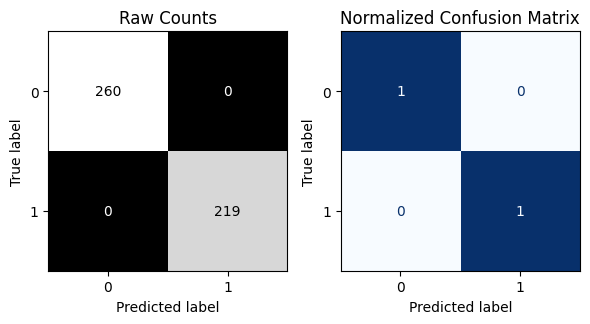


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.74      0.80       111
           1       0.55      0.73      0.63        49

    accuracy                           0.74       160
   macro avg       0.71      0.74      0.71       160
weighted avg       0.77      0.74      0.75       160



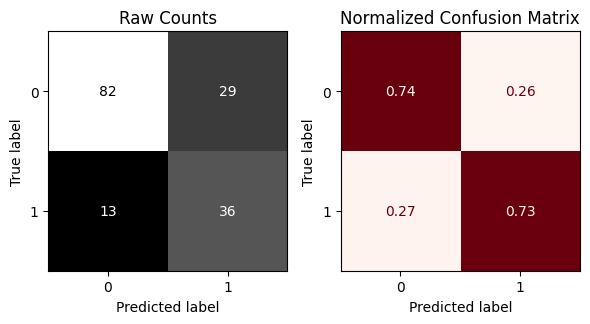

In [ ]:
evaluate_classification(rf_pipe, X_train, y_train, X_test, y_test)

The Random Forest model clearly overfits the training data, but it still performs surprisingly well on the test set especially in terms of recall for diabetic cases (Outcome = 1), which is our main focus.

Because of this, the default Random Forest is a strong option, but due to the overfitting, hyperparameter tuning is a must.

### 4.2.b: Hyperparameter Tuning using GridSearchCV

In [ ]:
rf_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('ordinal',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('ordinalencoder',
                                                     OrdinalEncoder(categories=[['underweight',
                                                                                 'healthy '
                                                                                 'weight',
                                                                                 'overweight',
                                                                                 'obese_1',
                                                                                 'obese_2',
                                                                                 'obese_3'],
                

In [ ]:
param_grid = {
    'randomforestclassifier__n_estimators': [50, 100, 200],
    'randomforestclassifier__max_depth': [None, 10, 15, 20],
    'randomforestclassifier__min_samples_split': [2, 5, 10],
    'randomforestclassifier__min_samples_leaf': [1, 2, 4],
    'randomforestclassifier__max_features': ['sqrt', 'log2'],
    'randomforestclassifier__bootstrap': [True],
    'randomforestclassifier__class_weight': ['balanced', None]
}

gs_rf = GridSearchCV(rf_pipe, param_grid, verbose=True, n_jobs=-1,
                  return_train_score=True,scoring='recall_macro')

gs_rf.fit(X_train, y_train)
print(f'Best Params: {gs_rf.best_params_}')

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Params: {'randomforestclassifier__bootstrap': True, 'randomforestclassifier__class_weight': None, 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__n_estimators': 50}


----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.92      0.92       260
           1       0.91      0.89      0.90       219

    accuracy                           0.91       479
   macro avg       0.91      0.91      0.91       479
weighted avg       0.91      0.91      0.91       479



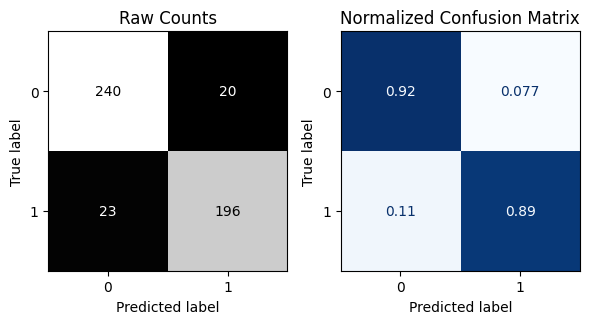


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.77      0.82       111
           1       0.59      0.76      0.66        49

    accuracy                           0.76       160
   macro avg       0.73      0.76      0.74       160
weighted avg       0.79      0.76      0.77       160



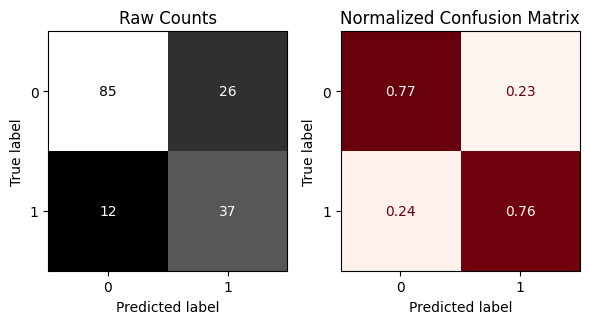

In [ ]:
best_rf = gs_rf.best_estimator_
evaluate_classification(best_rf, X_train, y_train, X_test, y_test)

After tuning the Random Forest model with GridSearchCV, we saw better generalization and less overfitting. The tuned model, on the other hand, gave more balanced results. It improved recall for diabetic cases (Outcome = 1) and achieved a higher macro recall of 0.76 on the test set.

### 4.2.c: Evaluate Both Default and Tuned

<table style="width:100%; table-layout: fixed; border-collapse: collapse;">
  <tr>
    <th></th>
    <th style="text-align:center; border: 1px solid black;">Default</th>
    <th style="text-align:center; border: 1px solid black;">Tuned</th>
  </tr>
  <tr>
    <th style="text-align:left; border: 1px solid black;">Training Data</th>
    <td style="border: 1px solid black;">
      <table border="1" style="width:100%; border-collapse: collapse;">
        <tr><th>Class</th><th>Precision</th><th>Recall</th><th>F1-Score</th><th>Support</th></tr>
        <tr><td>0</td><td>1.00</td><td>1.00</td><td>1.00</td><td>260</td></tr>
        <tr><td>1</td><td>1.00</td><td>1.00</td><td>1.00</td><td>219</td></tr>
        <tr><td><b>Accuracy</b></td><td colspan="2"></td><td>1.00</td><td>479</td></tr>
        <tr><td><b>Macro Avg</b></td><td>1.00</td><td>1.00</td><td>1.00</td><td>479</td></tr>
        <tr><td><b>Weighted Avg</b></td><td>1.00</td><td>1.00</td><td>1.00</td><td>479</td></tr>
      </table>
    </td>
    <td style="border: 1px solid black;">
      <table border="1" style="width:100%; border-collapse: collapse;">
        <tr><th>Class</th><th>Precision</th><th>Recall</th><th>F1-Score</th><th>Support</th></tr>
        <tr><td>0</td><td>0.91</td><td>0.92</td><td>0.92</td><td>260</td></tr>
        <tr><td>1</td><td>0.91</td><td>0.89</td><td>0.90</td><td>219</td></tr>
        <tr><td><b>Accuracy</b></td><td colspan="2"></td><td>0.91</td><td>479</td></tr>
        <tr><td><b>Macro Avg</b></td><td>0.91</td><td>0.91</td><td>0.91</td><td>479</td></tr>
        <tr><td><b>Weighted Avg</b></td><td>0.91</td><td>0.91</td><td>0.91</td><td>479</td></tr>
      </table>
    </td>
  </tr>
  <tr>
    <th style="text-align:left; border: 1px solid black;">Test Data</th>
    <td style="border: 1px solid black;">
      <table border="1" style="width:100%; border-collapse: collapse;">
        <tr><th>Class</th><th>Precision</th><th>Recall</th><th>F1-Score</th><th>Support</th></tr>
        <tr><td>0</td><td>0.86</td><td>0.74</td><td>0.80</td><td>111</td></tr>
        <tr><td>1</td><td>0.55</td><td>0.73</td><td>0.63</td><td>49</td></tr>
        <tr><td><b>Accuracy</b></td><td colspan="2"></td><td>0.74</td><td>160</td></tr>
        <tr><td><b>Macro Avg</b></td><td>0.71</td><td>0.74</td><td>0.71</td><td>160</td></tr>
        <tr><td><b>Weighted Avg</b></td><td>0.77</td><td>0.74</td><td>0.75</td><td>160</td></tr>
      </table>
    </td>
    <td style="border: 1px solid black;">
      <table border="1" style="width:100%; border-collapse: collapse;">
        <tr><th>Class</th><th>Precision</th><th>Recall</th><th>F1-Score</th><th>Support</th></tr>
        <tr><td>0</td><td>0.88</td><td>0.77</td><td>0.82</td><td>111</td></tr>
        <tr><td>1</td><td>0.59</td><td>0.76</td><td>0.66</td><td>49</td></tr>
        <tr><td><b>Accuracy</b></td><td colspan="2"></td><td>0.76</td><td>160</td></tr>
        <tr><td><b>Macro Avg</b></td><td>0.73</td><td>0.76</td><td>0.74</td><td>160</td></tr>
        <tr><td><b>Weighted Avg</b></td><td>0.79</td><td>0.76</td><td>0.77</td><td>160</td></tr>
      </table>
    </td>
  </tr>
</table>

Between the default and tuned Random Forest models, the tuned one is the better choice for predicting diabetes.

The default model fits the training data perfectly but overfits, leading to lower test performance (74% accuracy, F1-score 0.63 for diabetics). The tuned model has slightly lower training accuracy (91%) but performs better on the test set, with 76% accuracy and a higher F1-score (0.66) for diabetic cases. It also has improved recall from 0.73 to 0.76, which helps reduce false negatives.

Conclusion: the tuned model generalizes better and detects diabetes cases more reliably, and with less overfit making it more suitable for use.


## **4.3:  K-Nearest Neighbors**

### 4.3.a: Default KNN Model

In [ ]:
# Make an instance of the model
knn = KNeighborsClassifier()

# Create pipeline
knn_pipe = make_pipeline(preprocessor, knn)

# Training the model on the data, storing the information learned from the data
# Model is learning the relationship between X and y
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(categories=[['underweight',
                                                                                               'healthy '
                                                                                               'weight',
                                                                                               'overweight',
                                                                                               'obese_1',
                                                                                               'obese_2',
                                                                                               'obese_3'],
                                                                                              ['18 '
                                                                                               '- '
                                                                                               '44',
                                                                                               '45 '
                                                                                               '- '
                                                                                               '65',
                                                                                               '>65']])),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  [...
                                                                                 sparse_output=False))]),
                                                  ['Gender']),
                                                 ('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'DiabetesPedigreeFunction'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('kneighborsclassifier', KNeighborsClassifier())])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       260
           1       0.76      0.80      0.78       219

    accuracy                           0.80       479
   macro avg       0.79      0.80      0.79       479
weighted avg       0.80      0.80      0.80       479



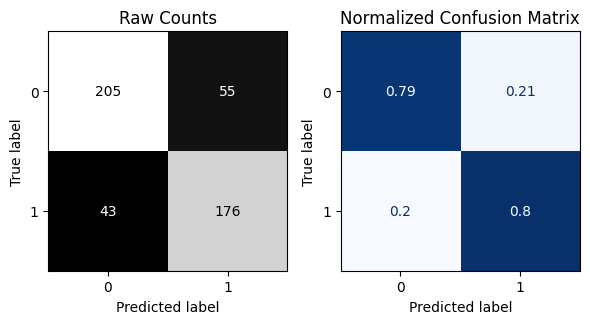


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.70      0.76       111
           1       0.51      0.69      0.59        49

    accuracy                           0.70       160
   macro avg       0.67      0.70      0.68       160
weighted avg       0.74      0.70      0.71       160



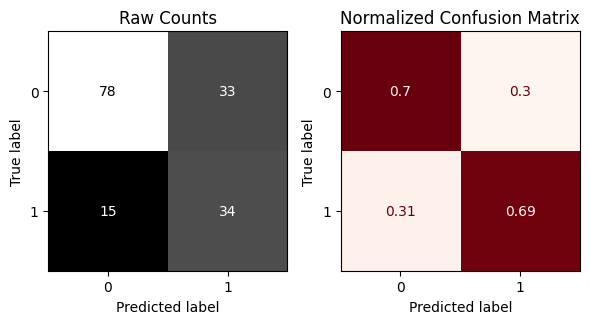

In [ ]:
evaluate_classification(knn_pipe, X_train, y_train, X_test, y_test)

### 4.3.b: Hyperparameter Tuning using GridSearchCV

In [ ]:
knn_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('ordinal',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('ordinalencoder',
                                                     OrdinalEncoder(categories=[['underweight',
                                                                                 'healthy '
                                                                                 'weight',
                                                                                 'overweight',
                                                                                 'obese_1',
                                                                                 'obese_2',
                                                                                 'obese_3'],
                

In [ ]:
param_grid = {
    'kneighborsclassifier__n_neighbors': list(range(5, 33, 2)),
    'kneighborsclassifier__weights': ['uniform'],
    'kneighborsclassifier__p': [1, 2],
    'kneighborsclassifier__algorithm': ['auto']
}

gs_knn = GridSearchCV(knn_pipe, param_grid, verbose=True, n_jobs=-1,
                  return_train_score=True,scoring='recall_macro')

gs_knn.fit(X_train, y_train)
print(f'Best Params: {gs_knn.best_params_}')

Fitting 5 folds for each of 28 candidates, totalling 140 fits
Best Params: {'kneighborsclassifier__algorithm': 'auto', 'kneighborsclassifier__n_neighbors': 29, 'kneighborsclassifier__p': 2, 'kneighborsclassifier__weights': 'uniform'}


----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.75      0.77       260
           1       0.72      0.76      0.74       219

    accuracy                           0.76       479
   macro avg       0.75      0.76      0.75       479
weighted avg       0.76      0.76      0.76       479



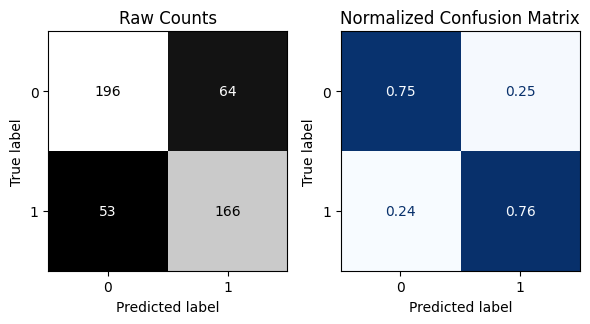


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.82      0.72      0.77       111
           1       0.50      0.63      0.56        49

    accuracy                           0.69       160
   macro avg       0.66      0.68      0.66       160
weighted avg       0.72      0.69      0.70       160



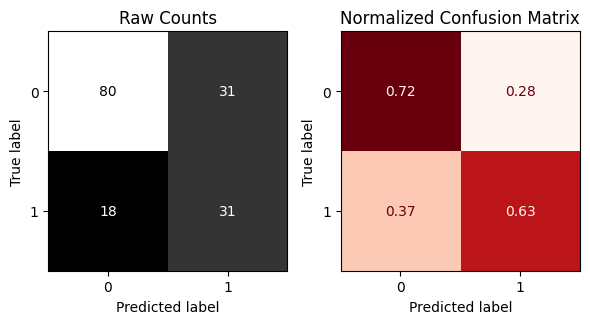

In [ ]:
best_knn = gs_knn.best_estimator_
evaluate_classification(best_knn, X_train, y_train, X_test, y_test)

After tuning the KNN model by increasing the number of neighbors to 29 and using uniform weighting, the model overfits less than before, but the test performance stayed about the same, with a macro recall slightly decreasing to 0.68.

KNN continues to struggle with the positive class (Outcome = 1), showing lower precision and recall for that class. This suggests that KNN may have limits on this dataset, and improving results might need better features or trying different models.

### 4.3.c: Evaluate Both Default and Tuned

<table style="width:100%; table-layout: fixed; border-collapse: collapse;">
  <tr>
    <th></th>
    <th style="text-align:center; border: 1px solid black;">Default</th>
    <th style="text-align:center; border: 1px solid black;">Tuned</th>
  </tr>
  <tr>
    <th style="text-align:left; border: 1px solid black;">Training Data</th>
    <td style="border: 1px solid black;">
      <table border="1" style="width:100%; border-collapse: collapse;">
        <tr><th>Class</th><th>Precision</th><th>Recall</th><th>F1-Score</th><th>Support</th></tr>
        <tr><td>0</td><td>0.83</td><td>0.79</td><td>0.81</td><td>260</td></tr>
        <tr><td>1</td><td>0.76</td><td>0.80</td><td>0.78</td><td>219</td></tr>
        <tr><td><b>Accuracy</b></td><td colspan="2"></td><td>0.80</td><td>479</td></tr>
        <tr><td><b>Macro Avg</b></td><td>0.79</td><td>0.80</td><td>0.79</td><td>479</td></tr>
        <tr><td><b>Weighted Avg</b></td><td>0.80</td><td>0.80</td><td>0.80</td><td>479</td></tr>
      </table>
    </td>
    <td style="border: 1px solid black;">
      <table border="1" style="width:100%; border-collapse: collapse;">
        <tr><th>Class</th><th>Precision</th><th>Recall</th><th>F1-Score</th><th>Support</th></tr>
        <tr><td>0</td><td>0.79</td><td>0.75</td><td>0.77</td><td>260</td></tr>
        <tr><td>1</td><td>0.72</td><td>0.76</td><td>0.74</td><td>219</td></tr>
        <tr><td><b>Accuracy</b></td><td colspan="2"></td><td>0.76</td><td>479</td></tr>
        <tr><td><b>Macro Avg</b></td><td>0.75</td><td>0.76</td><td>0.75</td><td>479</td></tr>
        <tr><td><b>Weighted Avg</b></td><td>0.76</td><td>0.76</td><td>0.76</td><td>479</td></tr>
      </table>
    </td>
  </tr>
  <tr>
    <th style="text-align:left; border: 1px solid black;">Test Data</th>
    <td style="border: 1px solid black;">
      <table border="1" style="width:100%; border-collapse: collapse;">
        <tr><th>Class</th><th>Precision</th><th>Recall</th><th>F1-Score</th><th>Support</th></tr>
        <tr><td>0</td><td>0.84</td><td>0.70</td><td>0.76</td><td>111</td></tr>
        <tr><td>1</td><td>0.51</td><td>0.69</td><td>0.59</td><td>49</td></tr>
        <tr><td><b>Accuracy</b></td><td colspan="2"></td><td>0.70</td><td>160</td></tr>
        <tr><td><b>Macro Avg</b></td><td>0.67</td><td>0.70</td><td>0.68</td><td>160</td></tr>
        <tr><td><b>Weighted Avg</b></td><td>0.74</td><td>0.70</td><td>0.71</td><td>160</td></tr>
      </table>
    </td>
    <td style="border: 1px solid black;">
      <table border="1" style="width:100%; border-collapse: collapse;">
        <tr><th>Class</th><th>Precision</th><th>Recall</th><th>F1-Score</th><th>Support</th></tr>
        <tr><td>0</td><td>0.82</td><td>0.72</td><td>0.77</td><td>111</td></tr>
        <tr><td>1</td><td>0.50</td><td>0.63</td><td>0.56</td><td>49</td></tr>
        <tr><td><b>Accuracy</b></td><td colspan="2"></td><td>0.69</td><td>160</td></tr>
        <tr><td><b>Macro Avg</b></td><td>0.66</td><td>0.68</td><td>0.66</td><td>160</td></tr>
        <tr><td><b>Weighted Avg</b></td><td>0.72</td><td>0.69</td><td>0.70</td><td>160</td></tr>
      </table>
    </td>
  </tr>
</table>

In evaluating both the default and tuned K-Nearest Neighbors (KNN) models, we find that the default KNN model performs slightly better overall, particularly in identifying diabetic cases (Outcome = 1), which is the primary focus of this classification task.

The default KNN model achieved a test accuracy of 70%, with a recall of 0.69 and F1-score of 0.59 for the diabetic class. These metrics are slightly higher than those of the tuned model, which had a test accuracy of 69%, recall of 0.63, and F1-score of 0.56 for class 1. While tuning reduced training performance slightly (indicating less overfitting), it did not lead to meaningful gains on the test set.

In medical prediction problems such as diabetes diagnosis, recall is a critical metric, as failing to identify a diabetic case (false negative) could have serious consequences. Given that the default KNN model achieves better recall and F1-score for the positive class, it is the preferred choice between the two.

However, it is worth noting that both versions of KNN underperform compared to the tuned Random Forest model, which achieved stronger performance across all key metrics.

Conclusion: The default KNN model is better than the tuned version.

# **5) Evaluation of Model Results**

<h4 style="margin-top:20px;">Test Data Performance Comparison</h4>
<table style="width:100%; table-layout: fixed; border-collapse: collapse;">
  <tr>
    <th></th>
    <th style="text-align:center; border: 1px solid black;">Logistic Regression (Tuned)</th>
    <th style="text-align:center; border: 1px solid black;">Random Forest (Tuned)</th>
    <th style="text-align:center; border: 1px solid black;">KNN (Default)</th>
  </tr>
  <tr>
    <th style="text-align:left; border: 1px solid black;">Test Data</th>
    <td style="border: 1px solid black;">
      <table border="1" style="width:100%; border-collapse: collapse;">
        <tr><th>Class</th><th>Precision</th><th>Recall</th><th>F1-Score</th><th>Support</th></tr>
        <tr><td>0</td><td>0.84</td><td>0.75</td><td>0.79</td><td>111</td></tr>
        <tr><td>1</td><td>0.54</td><td>0.67</td><td>0.60</td><td>49</td></tr>
        <tr><td><b>Accuracy</b></td><td colspan="2"></td><td>0.72</td><td>160</td></tr>
        <tr><td><b>Macro Avg</b></td><td>0.69</td><td>0.71</td><td>0.70</td><td>160</td></tr>
        <tr><td><b>Weighted Avg</b></td><td>0.75</td><td>0.72</td><td>0.73</td><td>160</td></tr>
      </table>
    </td>
    <td style="border: 1px solid black;">
      <table border="1" style="width:100%; border-collapse: collapse;">
        <tr><th>Class</th><th>Precision</th><th>Recall</th><th>F1-Score</th><th>Support</th></tr>
        <tr><td>0</td><td>0.88</td><td>0.77</td><td>0.82</td><td>111</td></tr>
        <tr><td>1</td><td>0.59</td><td>0.76</td><td>0.66</td><td>49</td></tr>
        <tr><td><b>Accuracy</b></td><td colspan="2"></td><td>0.76</td><td>160</td></tr>
        <tr><td><b>Macro Avg</b></td><td>0.73</td><td>0.76</td><td>0.74</td><td>160</td></tr>
        <tr><td><b>Weighted Avg</b></td><td>0.79</td><td>0.76</td><td>0.77</td><td>160</td></tr>
      </table>
    </td>
    <td style="border: 1px solid black;">
      <table border="1" style="width:100%; border-collapse: collapse;">
        <tr><th>Class</th><th>Precision</th><th>Recall</th><th>F1-Score</th><th>Support</th></tr>
        <tr><td>0</td><td>0.84</td><td>0.70</td><td>0.76</td><td>111</td></tr>
        <tr><td>1</td><td>0.51</td><td>0.69</td><td>0.59</td><td>49</td></tr>
        <tr><td><b>Accuracy</b></td><td colspan="2"></td><td>0.70</td><td>160</td></tr>
        <tr><td><b>Macro Avg</b></td><td>0.67</td><td>0.70</td><td>0.68</td><td>160</td></tr>
        <tr><td><b>Weighted Avg</b></td><td>0.74</td><td>0.70</td><td>0.71</td><td>160</td></tr>
      </table>
    </td>
  </tr>
</table>

After evaluating the models (tuned Logistic Regression, tuned Random Forest, and default K-Nearest Neighbors (KNN)), the tuned Random Forest classifier was selected as the best performing model.

RF:
* It had the highest test accuracy (76%).
* It gave the best recall (0.76) and F1-score (0.66) for the diabetic class (Outcome = 1), which is our top priority.
* It generalizes well and avoids overfitting better than the default models.

While Logistic Regression and KNN did okay, they didn’t match Random Forest’s ability to detect diabetic cases.

**Conclusion:**
In medical predictions, catching as many true cases as possible is key. So, the tuned Random Forest is the most reliable model and is recommended for deployment.



## ROC Curves

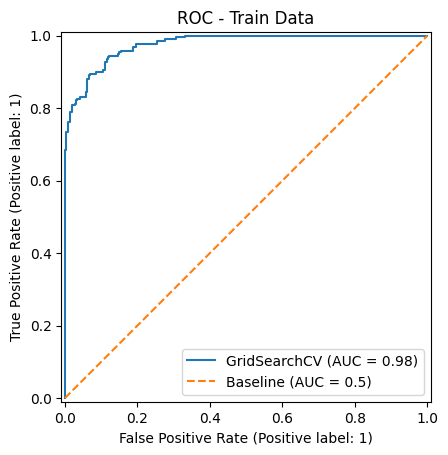

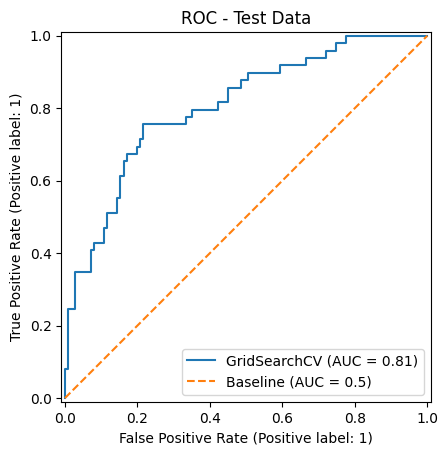

In [ ]:
# Visualize the ROC curve
RocCurveDisplay.from_estimator(gs_rf, X_train, y_train)
plt.plot([0, 1], [0, 1], ls = '--', label = 'Baseline (AUC = 0.5)')
plt.legend();
plt.title("ROC - Train Data");

RocCurveDisplay.from_estimator(gs_rf, X_test, y_test)
plt.plot([0, 1], [0, 1], ls = '--', label = 'Baseline (AUC = 0.5)')
plt.legend();
plt.title("ROC - Test Data");

The Random Forest classifier achieved AUC of 0.81 on test data, showing it's strong ability to separate  between diabetic and non-diabetic cases effectively, ensuring high sensitivity  while keeping false negative relatively low across different thresholds.

The high training AUC of 0.98 shows excellent model fit, and while it considers an overfitting, the strong test AUC confirms that the model generalizes well and is suitable for real-world prediction tasks where catching true positive cases is essential.




# **Final Conclusion**

Our final model, based on a tuned Random Forest algorithm, has shown strong and reliable performance in identifying individuals who are likely to have diabetes based on their health data.

The model was able to correctly catch 76% of people who actually have diabetes. This means that out of every 100 individuals who truly have the condition, the model successfully detects 76 of them, helping to minimize the risk of missing true cases (false negatives), which is crucial in medical decision making.

In addition, when the model predicts that someone has diabetes, it is correct about 59% of the time. While this leaves some room for improvement, it reflects a balanced trade-off between catching real cases and avoiding too many false alarms.